In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
# Data load 

df = pd.read_csv('/Users/hwangtaeeon/Documents/GitHub/Data-AI/Care_Duration_Prediction_Model/Data_Preprocessing/Regular_Expression/final_data.csv')
print(df.describe())
print(df.info())
print(df.columns)
print(df.head())
print('*'*50)
print('*'*50)
print()

            성별_남자       성별_여자    수술여부_아니오      수술여부_예   연령대_30세미만  연령대_30-39세  \
count  202.000000  201.000000  171.000000  171.000000  200.000000  202.000000   
mean   165.689604  158.256219  164.512865  206.118713  141.908000  158.798515   
std     99.556669  106.040246   99.184834  109.910184   94.223487  103.949056   
min     19.600000   29.500000   27.200000   55.000000   12.500000   18.500000   
25%     87.625000   82.500000   89.750000  116.400000   72.475000   83.950000   
50%    142.450000  133.300000  145.900000  180.000000  116.000000  132.300000   
75%    221.475000  201.500000  213.000000  273.850000  187.425000  216.150000   
max    514.500000  653.700000  509.400000  581.400000  525.500000  627.400000   

       연령대_40-49세  연령대_50-59세   연령대_60세이상   지역본부_서울지역   지역본부_부산지역   지역본부_대구지역  \
count  202.000000  202.000000  202.000000  202.000000  202.000000  202.000000   
mean   172.201980  174.507426  172.778713  164.415347  184.128713  164.855941   
std    101.406174  103.4734

In [3]:
# Create data set

genders = ['성별_남자', '성별_여자']
surgeries = ['수술여부_예', '수술여부_아니오']
ages = ['연령대_30세미만', '연령대_30-39세', '연령대_40-49세', '연령대_50-59세', '연령대_60세이상']
regions = ['지역본부_서울지역', '지역본부_부산지역', '지역본부_대구지역', '지역본부_경인지역', '지역본부_광주지역', '지역본부_대전지역']

combinations = list(itertools.product(genders, surgeries, ages, regions))

data_set = []

for _, row in df.iterrows():
    disease = row['병명']
    for gender, surgery, age, region in combinations:
        input_row = [disease, gender, surgery, age, region]
        output_row = [
            row.get(gender, None),
            row.get(surgery, None),
            row.get(age, None),
            row.get(region, None)
        ]
        data_set.append(input_row + output_row)
data_df = pd.DataFrame(data_set, columns=['병명', '성별', '수술여부', '연령대', '지역본부','성별_요양일', '수술여부_요양일', '연령대_요양일', '지역본부_요양일'])
print(data_df.head())
print('*'*50)
print('*'*50)
print()

          병명     성별    수술여부        연령대       지역본부  성별_요양일  수술여부_요양일  연령대_요양일  \
0  G510(벨마비)  성별_남자  수술여부_예  연령대_30세미만  지역본부_서울지역   164.0       NaN    148.7   
1  G510(벨마비)  성별_남자  수술여부_예  연령대_30세미만  지역본부_부산지역   164.0       NaN    148.7   
2  G510(벨마비)  성별_남자  수술여부_예  연령대_30세미만  지역본부_대구지역   164.0       NaN    148.7   
3  G510(벨마비)  성별_남자  수술여부_예  연령대_30세미만  지역본부_경인지역   164.0       NaN    148.7   
4  G510(벨마비)  성별_남자  수술여부_예  연령대_30세미만  지역본부_광주지역   164.0       NaN    148.7   

   지역본부_요양일  
0     182.0  
1     149.5  
2     194.6  
3     152.4  
4     168.9  
**************************************************
**************************************************



In [4]:
# Data Preprocessing 

# 결측치(NaN)가 있는 행 제거
data_df = data_df.dropna().reset_index(drop=True)
print(data_df.isna().sum())

# 복사본 유지
processed_df = data_df.copy()

# Label Encoding: 병명
le = LabelEncoder()
processed_df['병명'] = le.fit_transform(processed_df['병명'])

# One-Hot Encoding: 성별, 수술여부, 연령대, 지역본부
processed_df = processed_df.replace({True: 1, False: 0})
categorical_cols = ['성별', '수술여부', '연령대', '지역본부']
processed_df = pd.get_dummies(processed_df, columns=categorical_cols)

# 정규화: 출력값 4개
scaler = StandardScaler()
output_cols = ['성별_요양일', '수술여부_요양일', '연령대_요양일', '지역본부_요양일']
processed_df[output_cols] = scaler.fit_transform(processed_df[output_cols])

processed_df.to_csv('MLP_processed_prediction_data.csv', index=False)

병명          0
성별          0
수술여부        0
연령대         0
지역본부        0
성별_요양일      0
수술여부_요양일    0
연령대_요양일     0
지역본부_요양일    0
dtype: int64


In [5]:
# 📌 1. 데이터 불러오기 및 입력/출력 정의
df = pd.read_csv("MLP_processed_prediction_data.csv")
input_columns = [col for col in df.columns if col not in ['성별_요양일', '수술여부_요양일', '연령대_요양일', '지역본부_요양일']]
X = df[input_columns].astype(float).values
y = df[['성별_요양일', '수술여부_요양일', '연령대_요양일', '지역본부_요양일']].astype(float).values


In [6]:
# 📌 2. 학습/검증/테스트 셋 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# 📌 3. 텐서 변환
device = torch.device("cpu")
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [8]:
# 📌 4. 모델 정의
class MLPWithBottleneck(nn.Module):
    def __init__(self, input_dim):
        super(MLPWithBottleneck, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.multi_output_layer = nn.Linear(32, 4)
        self.bottleneck = nn.Sequential(
            nn.Linear(4, 1)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        multi_outputs = self.multi_output_layer(features)
        final_output = self.bottleneck(multi_outputs)
        return multi_outputs, final_output

In [9]:
# 📌 5. 모델 생성 및 학습 설정
input_dim = X_train.shape[1]
model = MLPWithBottleneck(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# 📌 6. 학습 루프
epochs = 500
early_stop_patience = 10
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_hat_4, y_hat_final = model(X_train)
    loss = criterion(y_hat_final.squeeze(), y_train.mean(dim=1))
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_y_hat_4, val_y_hat_final = model(X_valid)
        val_loss = criterion(val_y_hat_final.squeeze(), y_valid.mean(dim=1))

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

# 라벨값 -> 전체 데이터의 평균값으로 사용 !

In [11]:
# 📌 7. 테스트셋 예측 및 성능 평가
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    y_pred_4, y_pred_final = model(X_test)
    preds = y_pred_final.squeeze().cpu().numpy()
    targets = y_test.mean(dim=1).cpu().numpy()

    mse = np.mean((preds - targets) ** 2)
    mae = np.mean(np.abs(preds - targets))
    corr = np.corrcoef(preds, targets)[0, 1]

    print(f"\n✅ MSE: {mse:.4f}")
    print(f"✅ MAE: {mae:.4f}")
    print(f"📈 Pearson Correlation: {corr:.4f}")


✅ MSE: 0.7271
✅ MAE: 0.6691
📈 Pearson Correlation: 0.5339


/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52138/2041988024.py:10: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52138/2041988024.py:10: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52138/2041988024.py:10: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52138/2041988024.py:10: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52138/2041988024.py:10: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipyke

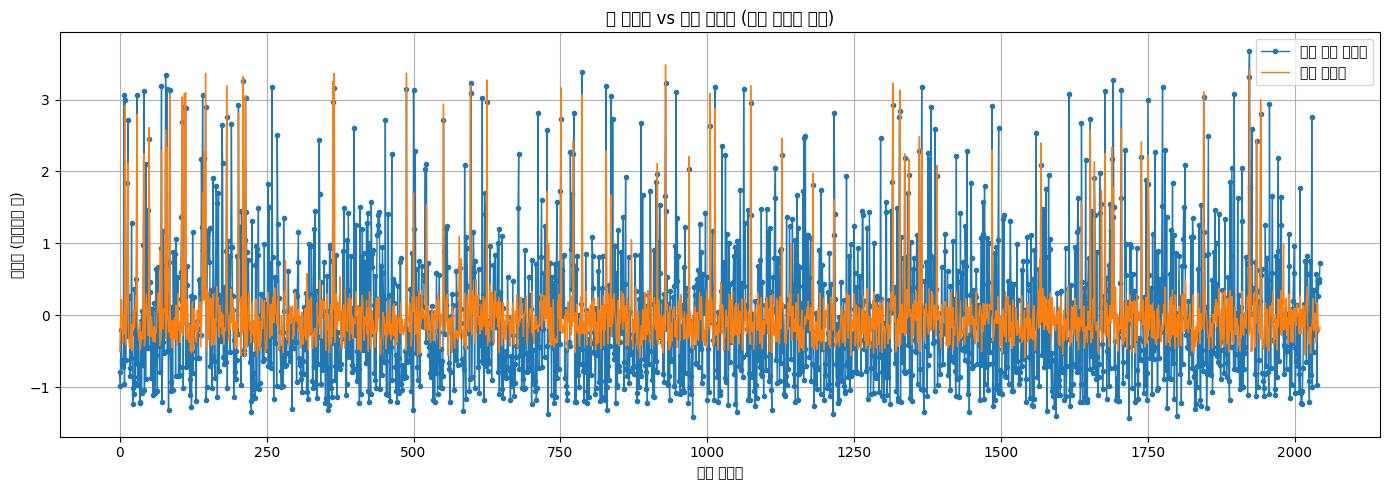

In [12]:
# 📊 8. 평균 예측 vs 실제 평균값 시각화
plt.figure(figsize=(14, 5))
plt.plot(targets, label="실제 평균 요양일", marker='o', markersize=3, linewidth=1)
plt.plot(preds, label="예측 요양일", markersize=3, linewidth=1)
plt.title("📊 예측값 vs 실제 평균값 (전체 테스트 샘플)")
plt.xlabel("샘플 인덱스")
plt.ylabel("요양일 (표준화된 값)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52138/2244775729.py:17: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52138/2244775729.py:17: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52138/2244775729.py:17: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52138/2244775729.py:17: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52138/2244775729.py:17: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipyke

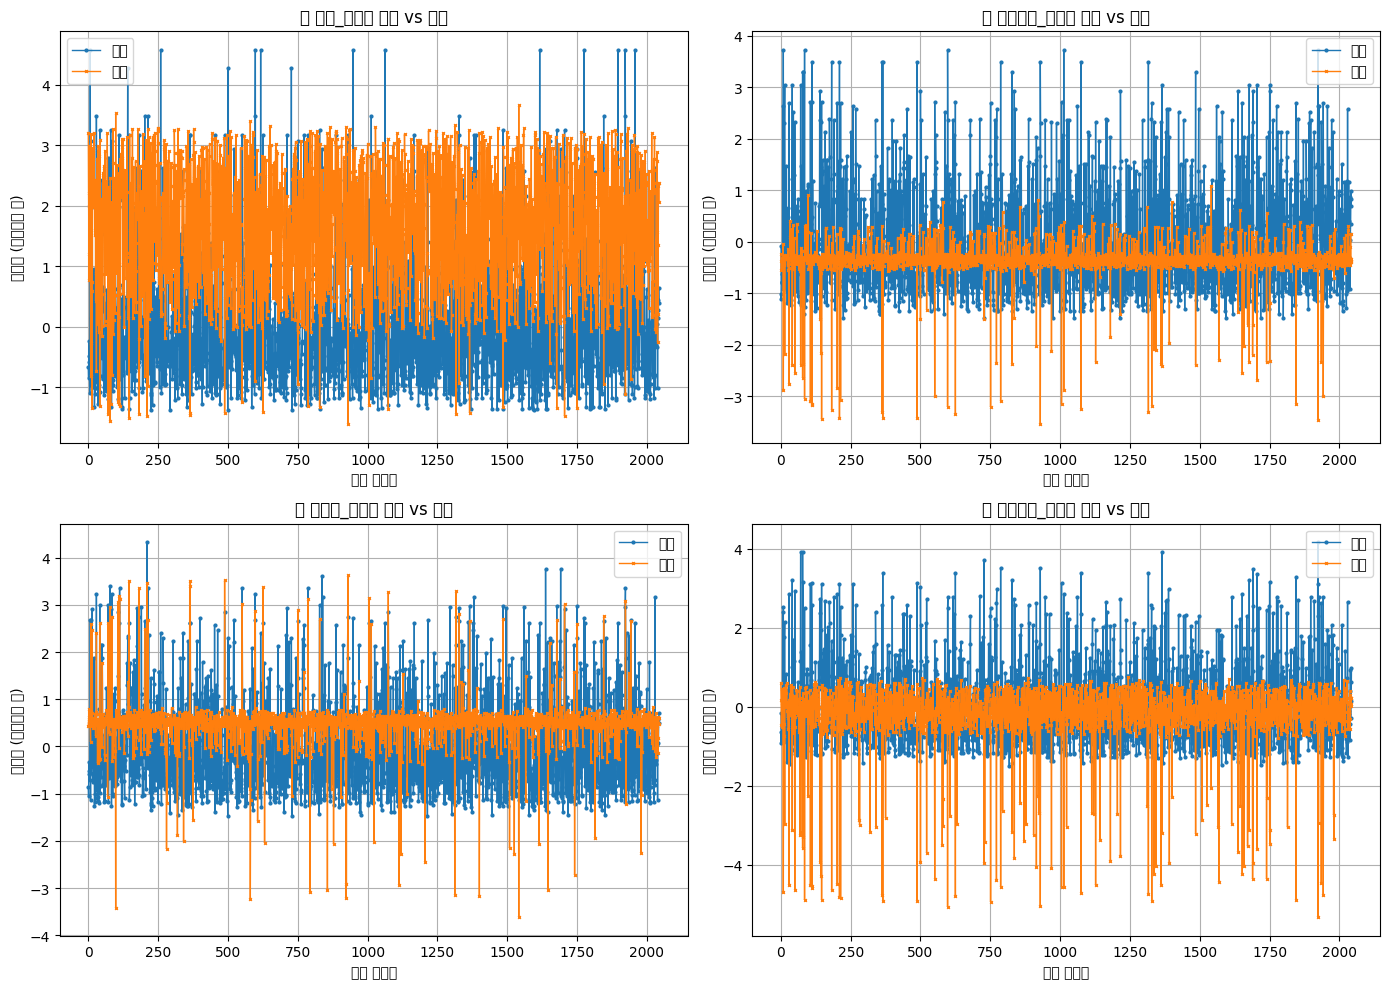

In [13]:
# 📊 9. multi_outputs (4개 요양일) 항목별 예측 vs 실제값 시각화
y_pred_4 = y_pred_4.cpu().numpy()
y_true_4 = y_test.cpu().numpy()
labels = ['성별_요양일', '수술여부_요양일', '연령대_요양일', '지역본부_요양일']

plt.figure(figsize=(14, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_true_4[:, i], label="실제", marker='o', markersize=2, linewidth=1)
    plt.plot(y_pred_4[:, i], label="예측", marker='x', markersize=2, linewidth=1)
    plt.title(f"📊 {labels[i]} 예측 vs 실제")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("요양일 (표준화된 값)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# 4개 요양일 예측값 vs 실제값 -> 역정규화